In [1]:
!pip install transformers --quiet
!pip install datasets --quiet

     |████████████████████████████████| 4.7 MB 5.2 MB/s 
     |████████████████████████████████| 101 kB 13.1 MB/s 
     |████████████████████████████████| 596 kB 68.4 MB/s 
     |████████████████████████████████| 6.6 MB 43.2 MB/s 
     |████████████████████████████████| 365 kB 8.3 MB/s 
     |████████████████████████████████| 141 kB 55.3 MB/s 
     |████████████████████████████████| 115 kB 65.1 MB/s 
     |████████████████████████████████| 212 kB 17.9 MB/s 
     |████████████████████████████████| 127 kB 7.1 MB/s 


In [2]:
import numpy as np
import pandas as pd 
from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments
from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

In [3]:
# tested in transformers==4.18.0, pytorch==1.7.1 
import torch
import transformers
torch.__version__, transformers.__version__

('1.12.0+cu113', '4.21.1')

*Note: the following code is for demonstration purpose. Please use GPU for fast inference on large scale dataset.*

In [4]:
torch.cuda.is_available()

True

### load dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv('/content/drive/MyDrive/final_dataset_formatted.csv') ## use your own customized dataset
df_test = pd.read_csv('/content/drive/MyDrive/final_dataset_formatted_test.csv')
df.head()

,sentence,label
0,Apache also has recycled more than 1.2 million...,1
1,We have the largest full-time union workforce ...,3
2,Comprehensive Risk We strengthened our busines...,7
3,"In 2011, Walmart China began a collaboration w...",2
4,"Wherever Agilent is in the world, we adhere to...",7


In [7]:
df = df.dropna(subset=['sentence', 'label']) ## drop missing values
df_test = df_test.dropna(subset=['sentence', 'label']) ## drop missing values

In [8]:
df.shape

(4050, 2)

### prepare training/validation/testing

In [9]:
df_train, df_val = train_test_split(df, stratify=df['label'],test_size=0.1, random_state=42)
print(df_train.shape, df_test.shape, df_val.shape)

(3645, 2) (450, 2) (405, 2)


### load FinBERT pretrained model
The pretrained FinBERT model path on Huggingface is https://huggingface.co/yiyanghkust/finbert-pretrain

In [10]:
model_name = 'bert-base-uncased'

In [11]:
model = BertForSequenceClassification.from_pretrained(model_name,num_labels=9)
tokenizer = BertTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### prepare dataset for fine-tuning

In [12]:
labels = ['CC', 'NC', 'PW', 'HC', 'PL', 'CR', 'CG', 'BE', 'N']

dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])


  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

### **First Trial:** 
### define training options

In [13]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy' : accuracy_score(predictions, labels), 'macro-f1' : f1_score(predictions, labels, average='macro')}

In [ ]:
args = TrainingArguments(
        output_dir = 'temp/',
        evaluation_strategy = 'epoch',
        save_strategy = 'epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
)

trainer = Trainer(
        model=model,                         # the instantiated 🤗 Transformers model to be trained
        args=args,                  # training arguments, defined above
        train_dataset=dataset_train,         # training dataset
        eval_dataset=dataset_val,            # evaluation dataset
        compute_metrics=compute_metrics
)

trainer.train()   

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3645
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 570


Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,No log,0.859890,0.812346,0.810614
2,No log,0.500443,0.861728,0.861376
3,No log,0.441712,0.861728,0.861344
4,No log,0.455498,0.869136,0.868627
5,0.589500,0.457251,0.864198,0.863692


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

TrainOutput(global_step=570, training_loss=0.5322596365945381, metrics={'train_runtime': 443.8924, 'train_samples_per_second': 41.057, 'train_steps_per_second': 1.284, 'total_flos': 1198875090758400.0, 'train_loss': 0.5322596365945381, 'epoch': 5.0})

### evaluate on validation set

In [ ]:
# generate prediction
predictions = trainer.predict(dataset_val)
print(predictions.metrics, '\n')
y_pred = np.array([np.argmax(pred) for pred in predictions[0]])

# evaluate model performance
f1 = f1_score(predictions[1], y_pred, average='macro')
print('accuracy %s' % accuracy_score(y_pred, predictions[1]))
print(f'macro_f1 score: {f1}')
print(classification_report(predictions[1], y_pred,target_names=labels))

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 405
  Batch size = 32


{'test_loss': 0.4554983377456665, 'test_accuracy': 0.8691358024691358, 'test_macro-f1': 0.8686266056704888, 'test_runtime': 3.2468, 'test_samples_per_second': 124.738, 'test_steps_per_second': 4.004} 

accuracy 0.8691358024691358
macro_f1 score: 0.8686266056704888
              precision    recall  f1-score   support

          CC       0.91      0.91      0.91        45
          NC       0.92      0.98      0.95        45
          PW       0.93      0.93      0.93        45
          HC       0.85      0.76      0.80        45
          PL       0.75      0.80      0.77        45
          CR       0.90      0.80      0.85        45
          CG       0.82      0.93      0.87        45
          BE       0.85      0.87      0.86        45
           N       0.90      0.84      0.87        45

    accuracy                           0.87       405
   macro avg       0.87      0.87      0.87       405
weighted avg       0.87      0.87      0.87       405



### save the fine-tuned model

In [ ]:
# trainer.save_model('finbert-sentiment/')

## **Fine-Tuning FinBERT Model**  
  
learning_rate   
weight_decay   
num_train_epochs  
per_device_train_batch_size  
per_device_eval_batch_size

In [14]:
# initial hyperparameters settings
learning_rate = 2e-5
weight_decay = 0
num_train_epochs = 5.0
per_device_train_batch_size = 32
per_device_eval_batch_size = 32

### learning_rate

In [ ]:
learning_rate_list = [1e-5, 3e-5, 5e-5, 7e-5, 9e-5]

best_learning_rate = 0
best_acc = 0
best_macro_f1 = 0

acc_list = list()
macro_f1_list = list()

for learning_rate in learning_rate_list:
  # reload pre-trained model
  model = BertForSequenceClassification.from_pretrained(model_name,num_labels=9)

  # set training arguments
  args = TrainingArguments(
          output_dir = 'temp/',
          evaluation_strategy = 'epoch',
          save_strategy = 'epoch',
          logging_strategy='epoch',
          learning_rate=learning_rate,
          per_device_train_batch_size=per_device_train_batch_size,
          per_device_eval_batch_size=per_device_eval_batch_size,
          num_train_epochs=num_train_epochs,
          weight_decay=weight_decay,
          load_best_model_at_end=True,
          metric_for_best_model='accuracy',
  )

  # set trainer
  trainer = Trainer(
          model=model,                         # the instantiated 🤗 Transformers model to be trained
          args=args,                  # training arguments, defined above
          train_dataset=dataset_train,         # training dataset
          eval_dataset=dataset_val,            # evaluation dataset
          compute_metrics=compute_metrics
  )

  # train model
  trainer.train() 

  # generate prediction
  predictions = trainer.predict(dataset_val)
  print(f'learning_rate: {learning_rate}\n', predictions.metrics, '\n')
  y_pred = np.array([np.argmax(pred) for pred in predictions[0]])

  # evaluate model performance
  acc = accuracy_score(y_pred, predictions[1])
  f1 = f1_score(predictions[1], y_pred, average='macro')
  print(f'accuracy {acc}')
  print(f'macro_f1 score: {f1}')
  print(classification_report(predictions[1], y_pred,target_names=labels))
  print('------------------------------------------------------------------------------------------------------')  
  acc_list.append(acc)
  macro_f1_list.append(f1)

  # save best model hyperparameter
  if best_acc < acc:
    best_acc = acc
    best_macro_f1 = f1
    best_learning_rate = learning_rate

print()
for i in range(len(learning_rate_list)):
  print(f'learning_rate: {learning_rate_list[i]}, acc: {acc_list[i]}, macro-f1: {macro_f1_list[i]}')
print()
print(f'Best Model: learning_rate = {best_learning_rate}, acc = {best_acc}, macro-f1 = {best_macro_f1}')

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "m

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,1.851200,1.422957,0.725926,0.723343
2,1.071000,0.798492,0.834568,0.834339
3,0.607100,0.591385,0.844444,0.844155
4,0.432600,0.526444,0.856790,0.856479
5,0.365400,0.506615,0.859259,0.859124


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "m

learning_rate: 1e-05
 {'test_loss': 0.5066152215003967, 'test_accuracy': 0.8592592592592593, 'test_macro-f1': 0.859124237735564, 'test_runtime': 3.2479, 'test_samples_per_second': 124.695, 'test_steps_per_second': 4.003} 

accuracy 0.8592592592592593
macro_f1 score: 0.859124237735564
              precision    recall  f1-score   support

          CC       0.87      0.87      0.87        45
          NC       0.91      0.93      0.92        45
          PW       0.89      0.91      0.90        45
          HC       0.82      0.82      0.82        45
          PL       0.80      0.78      0.79        45
          CR       0.86      0.82      0.84        45
          CG       0.80      0.91      0.85        45
          BE       0.93      0.87      0.90        45
           N       0.86      0.82      0.84        45

    accuracy                           0.86       405
   macro avg       0.86      0.86      0.86       405
weighted avg       0.86      0.86      0.86       405

----------

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceCla

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,1.299000,0.585833,0.837037,0.836214
2,0.375600,0.436690,0.869136,0.869024
3,0.169000,0.476692,0.869136,0.868833
4,0.082600,0.488855,0.871605,0.871086
5,0.046100,0.508476,0.871605,0.871282


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "m

learning_rate: 3e-05
 {'test_loss': 0.4888548254966736, 'test_accuracy': 0.8716049382716049, 'test_macro-f1': 0.8710858494486842, 'test_runtime': 3.2276, 'test_samples_per_second': 125.481, 'test_steps_per_second': 4.028} 

accuracy 0.8716049382716049
macro_f1 score: 0.8710858494486842
              precision    recall  f1-score   support

          CC       0.95      0.87      0.91        45
          NC       0.91      0.96      0.93        45
          PW       0.90      0.96      0.92        45
          HC       0.89      0.76      0.82        45
          PL       0.80      0.82      0.81        45
          CR       0.90      0.82      0.86        45
          CG       0.85      0.87      0.86        45
          BE       0.77      0.98      0.86        45
           N       0.90      0.82      0.86        45

    accuracy                           0.87       405
   macro avg       0.88      0.87      0.87       405
weighted avg       0.88      0.87      0.87       405

--------

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceCla

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,1.008900,0.507763,0.846914,0.845536
2,0.292700,0.450362,0.861728,0.861431
3,0.125200,0.504095,0.883951,0.883928
4,0.047700,0.553698,0.871605,0.871039
5,0.022600,0.565888,0.874074,0.873720


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "m

learning_rate: 5e-05
 {'test_loss': 0.5040954947471619, 'test_accuracy': 0.8839506172839506, 'test_macro-f1': 0.8839282543491177, 'test_runtime': 3.2377, 'test_samples_per_second': 125.088, 'test_steps_per_second': 4.015} 

accuracy 0.8839506172839506
macro_f1 score: 0.8839282543491177
              precision    recall  f1-score   support

          CC       0.93      0.89      0.91        45
          NC       0.91      0.96      0.93        45
          PW       0.89      0.91      0.90        45
          HC       0.84      0.91      0.87        45
          PL       0.83      0.84      0.84        45
          CR       0.92      0.80      0.86        45
          CG       0.79      0.98      0.87        45
          BE       0.95      0.80      0.87        45
           N       0.95      0.87      0.91        45

    accuracy                           0.88       405
   macro avg       0.89      0.88      0.88       405
weighted avg       0.89      0.88      0.88       405

--------

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceCla

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,0.915900,0.554801,0.849383,0.848376
2,0.259200,0.521215,0.849383,0.849095
3,0.113500,0.607389,0.864198,0.863736
4,0.045000,0.651541,0.854321,0.853929
5,0.016900,0.670667,0.854321,0.854030


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "m

learning_rate: 7e-05
 {'test_loss': 0.6073894500732422, 'test_accuracy': 0.8641975308641975, 'test_macro-f1': 0.8637355532004158, 'test_runtime': 3.222, 'test_samples_per_second': 125.7, 'test_steps_per_second': 4.035} 

accuracy 0.8641975308641975
macro_f1 score: 0.8637355532004158
              precision    recall  f1-score   support

          CC       0.91      0.87      0.89        45
          NC       0.95      0.91      0.93        45
          PW       0.88      0.93      0.90        45
          HC       0.81      0.84      0.83        45
          PL       0.85      0.73      0.79        45
          CR       0.88      0.84      0.86        45
          CG       0.76      0.98      0.85        45
          BE       0.88      0.78      0.82        45
           N       0.91      0.89      0.90        45

    accuracy                           0.86       405
   macro avg       0.87      0.86      0.86       405
weighted avg       0.87      0.86      0.86       405

-----------

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceCla

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,0.833700,0.541394,0.844444,0.843951
2,0.272400,0.493623,0.861728,0.861721
3,0.112600,0.644357,0.856790,0.855104
4,0.046400,0.660733,0.859259,0.859225
5,0.014600,0.639725,0.876543,0.876427


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

learning_rate: 9e-05
 {'test_loss': 0.6397249698638916, 'test_accuracy': 0.8765432098765432, 'test_macro-f1': 0.8764270157496328, 'test_runtime': 3.2245, 'test_samples_per_second': 125.602, 'test_steps_per_second': 4.032} 

accuracy 0.8765432098765432
macro_f1 score: 0.8764270157496328
              precision    recall  f1-score   support

          CC       0.95      0.87      0.91        45
          NC       0.93      0.96      0.95        45
          PW       0.88      0.96      0.91        45
          HC       0.81      0.87      0.84        45
          PL       0.82      0.82      0.82        45
          CR       0.93      0.82      0.87        45
          CG       0.82      0.93      0.87        45
          BE       0.86      0.84      0.85        45
           N       0.90      0.82      0.86        45

    accuracy                           0.88       405
   macro avg       0.88      0.88      0.88       405
weighted avg       0.88      0.88      0.88       405

--------

In [ ]:
learning_rate = best_learning_rate

### per_device_train_batch_size & per_device_eval_batch_size

In [ ]:
batch_size_list = [8, 16, 32, 64]

best_batch_size = 0
best_acc = 0
best_macro_f1 = 0

acc_list = list()
macro_f1_list = list()

for batch_size in batch_size_list:
  # reload pre-trained model
  model = BertForSequenceClassification.from_pretrained(model_name,num_labels=9)

  # set training arguments
  args = TrainingArguments(
          output_dir = 'temp/',
          evaluation_strategy = 'epoch',
          save_strategy = 'epoch',
          logging_strategy='epoch',
          learning_rate=learning_rate,
          per_device_train_batch_size=batch_size,
          per_device_eval_batch_size=batch_size,
          num_train_epochs=num_train_epochs,
          weight_decay=weight_decay,
          load_best_model_at_end=True,
          metric_for_best_model='accuracy',
  )

  # set trainer
  trainer = Trainer(
          model=model,                         # the instantiated 🤗 Transformers model to be trained
          args=args,                  # training arguments, defined above
          train_dataset=dataset_train,         # training dataset
          eval_dataset=dataset_val,            # evaluation dataset
          compute_metrics=compute_metrics
  )

  # train model
  trainer.train() 

  # generate prediction
  predictions = trainer.predict(dataset_val)
  print(f'batch_size: {batch_size}\n', predictions.metrics, '\n')
  y_pred = np.array([np.argmax(pred) for pred in predictions[0]])

  # evaluate model performance
  acc = accuracy_score(y_pred, predictions[1])
  f1 = f1_score(predictions[1], y_pred, average='macro')
  print(f'accuracy {acc}')
  print(f'macro_f1 score: {f1}')
  print(classification_report(predictions[1], y_pred,target_names=labels))
  print('------------------------------------------------------------------------------------------------------') 
  acc_list.append(acc)
  macro_f1_list.append(f1) 

  # save best model hyperparameter
  if best_acc < acc:
    best_acc = acc
    best_macro_f1 = f1
    best_batch_size = batch_size

print()
for i in range(len(batch_size_list)):
  print(f'batch_size: {batch_size_list[i]}, acc: {acc_list[i]}, macro-f1: {macro_f1_list[i]}')
print()
print(f'Best Model: batch_size = {best_batch_size}, acc = {best_acc}, macro-f1 = {best_macro_f1}')

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "m

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,0.746900,0.542893,0.854321,0.853657
2,0.250500,0.607841,0.871605,0.870675
3,0.105300,0.764564,0.874074,0.873915
4,0.046400,0.813010,0.879012,0.878999
5,0.013200,0.814536,0.881481,0.881422


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 8
Saving model checkpoint to temp/checkpoint-456
Configuration saved in temp/checkpoint-456/config.json
Model weights saved in temp/checkpoint-456/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 8
Saving model checkpoint to temp/checkpoint-912
Configuration saved in temp/checkpoint-912/c

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "m

batch_size: 8
 {'test_loss': 0.8145357370376587, 'test_accuracy': 0.8814814814814815, 'test_macro-f1': 0.881421822936434, 'test_runtime': 3.5506, 'test_samples_per_second': 114.066, 'test_steps_per_second': 14.364} 

accuracy 0.8814814814814815
macro_f1 score: 0.881421822936434
              precision    recall  f1-score   support

          CC       0.91      0.89      0.90        45
          NC       0.94      0.98      0.96        45
          PW       0.91      0.96      0.93        45
          HC       0.80      0.82      0.81        45
          PL       0.81      0.84      0.83        45
          CR       0.93      0.82      0.87        45
          CG       0.81      0.96      0.88        45
          BE       0.88      0.84      0.86        45
           N       0.97      0.82      0.89        45

    accuracy                           0.88       405
   macro avg       0.89      0.88      0.88       405
weighted avg       0.89      0.88      0.88       405

----------------

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceCla

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,0.818900,0.550773,0.834568,0.832622
2,0.247700,0.511368,0.874074,0.873486
3,0.100100,0.579902,0.864198,0.864401
4,0.034400,0.670860,0.864198,0.863888
5,0.010800,0.637756,0.864198,0.864202


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228/config.json
Model weights saved in temp/checkpoint-228/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-456
Configuration saved in temp/checkpoint-456

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "m

batch_size: 16
 {'test_loss': 0.5113683342933655, 'test_accuracy': 0.8740740740740741, 'test_macro-f1': 0.8734863226819791, 'test_runtime': 3.1614, 'test_samples_per_second': 128.109, 'test_steps_per_second': 8.224} 

accuracy 0.8740740740740741
macro_f1 score: 0.8734863226819791
              precision    recall  f1-score   support

          CC       0.89      0.89      0.89        45
          NC       0.95      0.91      0.93        45
          PW       0.88      0.98      0.93        45
          HC       0.85      0.78      0.81        45
          PL       0.82      0.80      0.81        45
          CR       0.91      0.87      0.89        45
          CG       0.79      0.98      0.87        45
          BE       0.88      0.80      0.84        45
           N       0.93      0.87      0.90        45

    accuracy                           0.87       405
   macro avg       0.88      0.87      0.87       405
weighted avg       0.88      0.87      0.87       405

--------------

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceCla

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,1.008900,0.507763,0.846914,0.845536
2,0.292700,0.450362,0.861728,0.861431
3,0.125200,0.504095,0.883951,0.883928
4,0.047700,0.553698,0.871605,0.871039
5,0.022600,0.565888,0.874074,0.873720


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "m

batch_size: 32
 {'test_loss': 0.5040954947471619, 'test_accuracy': 0.8839506172839506, 'test_macro-f1': 0.8839282543491177, 'test_runtime': 3.2766, 'test_samples_per_second': 123.604, 'test_steps_per_second': 3.968} 

accuracy 0.8839506172839506
macro_f1 score: 0.8839282543491177
              precision    recall  f1-score   support

          CC       0.93      0.89      0.91        45
          NC       0.91      0.96      0.93        45
          PW       0.89      0.91      0.90        45
          HC       0.84      0.91      0.87        45
          PL       0.83      0.84      0.84        45
          CR       0.92      0.80      0.86        45
          CG       0.79      0.98      0.87        45
          BE       0.95      0.80      0.87        45
           N       0.95      0.87      0.91        45

    accuracy                           0.88       405
   macro avg       0.89      0.88      0.88       405
weighted avg       0.89      0.88      0.88       405

--------------

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceCla

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,1.322000,0.598194,0.839506,0.838204
2,0.382100,0.482766,0.859259,0.858343
3,0.174300,0.510223,0.866667,0.866696
4,0.081100,0.504152,0.871605,0.871213
5,0.044200,0.498470,0.864198,0.863726


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 64
Saving model checkpoint to temp/checkpoint-57
Configuration saved in temp/checkpoint-57/config.json
Model weights saved in temp/checkpoint-57/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 64
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/co

batch_size: 64
 {'test_loss': 0.5041520595550537, 'test_accuracy': 0.8716049382716049, 'test_macro-f1': 0.8712131672012459, 'test_runtime': 3.2475, 'test_samples_per_second': 124.711, 'test_steps_per_second': 2.156} 

accuracy 0.8716049382716049
macro_f1 score: 0.8712131672012459
              precision    recall  f1-score   support

          CC       0.93      0.89      0.91        45
          NC       0.90      0.96      0.92        45
          PW       0.91      0.93      0.92        45
          HC       0.88      0.78      0.82        45
          PL       0.80      0.80      0.80        45
          CR       0.88      0.82      0.85        45
          CG       0.83      0.89      0.86        45
          BE       0.81      0.93      0.87        45
           N       0.93      0.84      0.88        45

    accuracy                           0.87       405
   macro avg       0.87      0.87      0.87       405
weighted avg       0.87      0.87      0.87       405

--------------

In [ ]:
# though memory error occurred, best model is batch_size=16, with acc=0.86667, and f1=0.866847
per_device_train_batch_size = best_batch_size
per_device_eval_batch_size = best_batch_size

### weight_decay

In [15]:
weight_decay_list = [0, 0.0001, 0.001, 0.01, 0.1]

best_weight_decay = 0
best_acc = 0
best_macro_f1 = 0

acc_list = list()
macro_f1_list = list()

for weight_decay in weight_decay_list:
  # reload pre-trained model
  model = BertForSequenceClassification.from_pretrained(model_name,num_labels=9)

  # set training arguments
  args = TrainingArguments(
          output_dir = 'temp/',
          evaluation_strategy = 'epoch',
          save_strategy = 'epoch',
          logging_strategy='epoch',
          learning_rate=learning_rate,
          per_device_train_batch_size=per_device_train_batch_size,
          per_device_eval_batch_size=per_device_eval_batch_size,
          num_train_epochs=num_train_epochs,
          weight_decay=weight_decay,
          load_best_model_at_end=True,
          metric_for_best_model='accuracy',
  )

  # set trainer
  trainer = Trainer(
          model=model,                         # the instantiated 🤗 Transformers model to be trained
          args=args,                  # training arguments, defined above
          train_dataset=dataset_train,         # training dataset
          eval_dataset=dataset_val,            # evaluation dataset
          compute_metrics=compute_metrics
  )

  # train model
  trainer.train() 

  # generate prediction
  predictions = trainer.predict(dataset_val)
  print(f'weight_decay: {weight_decay}\n', predictions.metrics, '\n')
  y_pred = np.array([np.argmax(pred) for pred in predictions[0]])

  # evaluate model performance
  acc = accuracy_score(y_pred, predictions[1])
  f1 = f1_score(predictions[1], y_pred, average='macro')
  print(f'accuracy {acc}')
  print(f'macro_f1 score: {f1}')
  print(classification_report(predictions[1], y_pred,target_names=labels))
  print('------------------------------------------------------------------------------------------------------') 
  acc_list.append(acc)
  macro_f1_list.append(f1)   

  # save best model hyperparameter
  if best_acc < acc:
    best_acc = acc
    best_macro_f1 = f1
    best_weight_decay = weight_decay

print()
for i in range(len(weight_decay_list)):
  print(f'weight_decay: {weight_decay_list[i]}, acc: {acc_list[i]}, macro-f1: {macro_f1_list[i]}')
print()
print(f'Best Model: weight_decay = {best_weight_decay}, acc = {best_acc}, macro-f1 = {best_macro_f1}')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,1.043500,0.530736,0.844444,0.842236
2,0.283200,0.524090,0.856790,0.856423
3,0.110100,0.537023,0.866667,0.866954
4,0.038700,0.587154,0.854321,0.854326
5,0.018300,0.605676,0.864198,0.864185


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "m

weight_decay: 0
 {'test_loss': 0.5370230674743652, 'test_accuracy': 0.8666666666666667, 'test_macro-f1': 0.8669536536810204, 'test_runtime': 3.1444, 'test_samples_per_second': 128.801, 'test_steps_per_second': 4.134} 

accuracy 0.8666666666666667
macro_f1 score: 0.8669536536810204
              precision    recall  f1-score   support

          CC       0.91      0.87      0.89        45
          NC       0.96      0.96      0.96        45
          PW       0.93      0.91      0.92        45
          HC       0.86      0.80      0.83        45
          PL       0.76      0.84      0.80        45
          CR       0.89      0.87      0.88        45
          CG       0.78      0.96      0.86        45
          BE       0.84      0.80      0.82        45
           N       0.92      0.80      0.86        45

    accuracy                           0.87       405
   macro avg       0.87      0.87      0.87       405
weighted avg       0.87      0.87      0.87       405

-------------

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceCla

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,1.008900,0.507763,0.846914,0.845536
2,0.292700,0.450362,0.861728,0.861431
3,0.125200,0.504095,0.883951,0.883928
4,0.047700,0.553698,0.871605,0.871039
5,0.022600,0.565888,0.874074,0.873720


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "m

weight_decay: 0.0001
 {'test_loss': 0.5040954947471619, 'test_accuracy': 0.8839506172839506, 'test_macro-f1': 0.8839282543491177, 'test_runtime': 3.1291, 'test_samples_per_second': 129.432, 'test_steps_per_second': 4.155} 

accuracy 0.8839506172839506
macro_f1 score: 0.8839282543491177
              precision    recall  f1-score   support

          CC       0.93      0.89      0.91        45
          NC       0.91      0.96      0.93        45
          PW       0.89      0.91      0.90        45
          HC       0.84      0.91      0.87        45
          PL       0.83      0.84      0.84        45
          CR       0.92      0.80      0.86        45
          CG       0.79      0.98      0.87        45
          BE       0.95      0.80      0.87        45
           N       0.95      0.87      0.91        45

    accuracy                           0.88       405
   macro avg       0.89      0.88      0.88       405
weighted avg       0.89      0.88      0.88       405

--------

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceCla

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,1.008800,0.504999,0.851852,0.850795
2,0.292000,0.448605,0.866667,0.866501
3,0.122700,0.508958,0.879012,0.878792
4,0.047400,0.565963,0.871605,0.871038
5,0.021900,0.578978,0.871605,0.871023


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "m

weight_decay: 0.001
 {'test_loss': 0.5089583992958069, 'test_accuracy': 0.8790123456790123, 'test_macro-f1': 0.8787919895229304, 'test_runtime': 3.1937, 'test_samples_per_second': 126.811, 'test_steps_per_second': 4.07} 

accuracy 0.8790123456790123
macro_f1 score: 0.8787919895229304
              precision    recall  f1-score   support

          CC       0.89      0.89      0.89        45
          NC       0.91      0.96      0.93        45
          PW       0.89      0.91      0.90        45
          HC       0.84      0.91      0.87        45
          PL       0.83      0.84      0.84        45
          CR       0.92      0.80      0.86        45
          CG       0.79      0.98      0.87        45
          BE       0.95      0.80      0.87        45
           N       0.95      0.82      0.88        45

    accuracy                           0.88       405
   macro avg       0.88      0.88      0.88       405
weighted avg       0.88      0.88      0.88       405

----------

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceCla

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,1.006400,0.508592,0.844444,0.843470
2,0.292500,0.446480,0.866667,0.866572
3,0.121800,0.508287,0.886420,0.886403
4,0.049200,0.562444,0.871605,0.870775
5,0.021800,0.573611,0.876543,0.875788


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "m

weight_decay: 0.01
 {'test_loss': 0.5082873702049255, 'test_accuracy': 0.8864197530864197, 'test_macro-f1': 0.8864032984191608, 'test_runtime': 3.1367, 'test_samples_per_second': 129.118, 'test_steps_per_second': 4.145} 

accuracy 0.8864197530864197
macro_f1 score: 0.8864032984191608
              precision    recall  f1-score   support

          CC       0.93      0.89      0.91        45
          NC       0.90      0.98      0.94        45
          PW       0.91      0.91      0.91        45
          HC       0.85      0.89      0.87        45
          PL       0.83      0.84      0.84        45
          CR       0.92      0.80      0.86        45
          CG       0.80      0.96      0.87        45
          BE       0.93      0.84      0.88        45
           N       0.95      0.87      0.91        45

    accuracy                           0.89       405
   macro avg       0.89      0.89      0.89       405
weighted avg       0.89      0.89      0.89       405

----------

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceCla

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,1.009500,0.508765,0.851852,0.850853
2,0.287700,0.442499,0.864198,0.864239
3,0.122500,0.511334,0.881481,0.881443
4,0.046700,0.564866,0.876543,0.876237
5,0.020900,0.545390,0.879012,0.878672


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

weight_decay: 0.1
 {'test_loss': 0.511333703994751, 'test_accuracy': 0.8814814814814815, 'test_macro-f1': 0.8814425383327618, 'test_runtime': 3.1717, 'test_samples_per_second': 127.693, 'test_steps_per_second': 4.099} 

accuracy 0.8814814814814815
macro_f1 score: 0.8814425383327618
              precision    recall  f1-score   support

          CC       0.95      0.91      0.93        45
          NC       0.93      0.96      0.95        45
          PW       0.91      0.91      0.91        45
          HC       0.80      0.91      0.85        45
          PL       0.83      0.78      0.80        45
          CR       0.92      0.80      0.86        45
          CG       0.77      0.98      0.86        45
          BE       0.95      0.80      0.87        45
           N       0.91      0.89      0.90        45

    accuracy                           0.88       405
   macro avg       0.89      0.88      0.88       405
weighted avg       0.89      0.88      0.88       405

------------

In [16]:
weight_decay = best_weight_decay

### num_train_epochs

In [17]:
num_train_epochs_list = [3, 4, 5, 6, 7, 8]

best_num_train_epochs = 0
best_acc = 0
best_macro_f1 = 0

acc_list = list()
macro_f1_list = list()

for num_train_epochs in num_train_epochs_list:
  # reload pre-trained model
  model = BertForSequenceClassification.from_pretrained(model_name,num_labels=9)

  # set training arguments
  args = TrainingArguments(
          output_dir = 'temp/',
          evaluation_strategy = 'epoch',
          save_strategy = 'epoch',
          logging_strategy='epoch',
          learning_rate=learning_rate,
          per_device_train_batch_size=per_device_train_batch_size,
          per_device_eval_batch_size=per_device_eval_batch_size,
          num_train_epochs=num_train_epochs,
          weight_decay=weight_decay,
          load_best_model_at_end=True,
          metric_for_best_model='accuracy',
  )

  # set trainer
  trainer = Trainer(
          model=model,                         # the instantiated 🤗 Transformers model to be trained
          args=args,                  # training arguments, defined above
          train_dataset=dataset_train,         # training dataset
          eval_dataset=dataset_val,            # evaluation dataset
          compute_metrics=compute_metrics
  )

  # train model
  trainer.train() 

  # generate prediction
  predictions = trainer.predict(dataset_val)
  print(f'num_train_epochs: {num_train_epochs}\n', predictions.metrics, '\n')
  y_pred = np.array([np.argmax(pred) for pred in predictions[0]])

  # evaluate model performance
  acc = accuracy_score(y_pred, predictions[1])
  f1 = f1_score(predictions[1], y_pred, average='macro')
  print(f'accuracy {acc}')
  print(f'macro_f1 score: {f1}')
  print(classification_report(predictions[1], y_pred,target_names=labels))
  print('------------------------------------------------------------------------------------------------------')
  acc_list.append(acc)
  macro_f1_list.append(f1)  

  # save best model hyperparameter
  if best_acc < acc:
    best_acc = acc
    best_macro_f1 = f1
    best_num_train_epochs = num_train_epochs

print()
for i in range(len(num_train_epochs_list)):
  print(f'num_train_epochs: {num_train_epochs_list[i]}, acc: {acc_list[i]}, macro-f1: {macro_f1_list[i]}')
print()
print(f'Best Model: num_train_epochs = {best_num_train_epochs}, acc = {best_acc}, macro-f1 = {best_macro_f1}')

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "m

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,1.015900,0.504264,0.839506,0.838765
2,0.284300,0.425045,0.879012,0.878733
3,0.121900,0.463089,0.869136,0.869000


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "m

num_train_epochs: 3
 {'test_loss': 0.425045371055603, 'test_accuracy': 0.8790123456790123, 'test_macro-f1': 0.8787334031764286, 'test_runtime': 3.1357, 'test_samples_per_second': 129.159, 'test_steps_per_second': 4.146} 

accuracy 0.8790123456790123
macro_f1 score: 0.8787334031764286
              precision    recall  f1-score   support

          CC       0.87      0.91      0.89        45
          NC       0.91      0.96      0.93        45
          PW       0.89      0.91      0.90        45
          HC       0.86      0.82      0.84        45
          PL       0.84      0.82      0.83        45
          CR       0.90      0.82      0.86        45
          CG       0.87      0.91      0.89        45
          BE       0.82      0.91      0.86        45
           N       0.95      0.84      0.89        45

    accuracy                           0.88       405
   macro avg       0.88      0.88      0.88       405
weighted avg       0.88      0.88      0.88       405

----------

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceCla

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,1.110900,0.534662,0.834568,0.833613
2,0.295500,0.459643,0.861728,0.861733
3,0.112500,0.482000,0.891358,0.891147
4,0.045100,0.523136,0.879012,0.878830


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "m

num_train_epochs: 4
 {'test_loss': 0.48199960589408875, 'test_accuracy': 0.891358024691358, 'test_macro-f1': 0.8911469839728205, 'test_runtime': 3.1295, 'test_samples_per_second': 129.412, 'test_steps_per_second': 4.154} 

accuracy 0.891358024691358
macro_f1 score: 0.8911469839728205
              precision    recall  f1-score   support

          CC       0.91      0.89      0.90        45
          NC       0.96      0.98      0.97        45
          PW       0.91      0.93      0.92        45
          HC       0.85      0.89      0.87        45
          PL       0.86      0.80      0.83        45
          CR       0.91      0.89      0.90        45
          CG       0.79      0.98      0.87        45
          BE       0.95      0.80      0.87        45
           N       0.93      0.87      0.90        45

    accuracy                           0.89       405
   macro avg       0.90      0.89      0.89       405
weighted avg       0.90      0.89      0.89       405

----------

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceCla

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,1.036500,0.508233,0.829630,0.828804
2,0.284600,0.488662,0.856790,0.856963
3,0.114700,0.493356,0.864198,0.863551
4,0.046200,0.581020,0.866667,0.865433
5,0.020400,0.582234,0.866667,0.866129


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "m

num_train_epochs: 5
 {'test_loss': 0.5810199975967407, 'test_accuracy': 0.8666666666666667, 'test_macro-f1': 0.8654333121063111, 'test_runtime': 3.135, 'test_samples_per_second': 129.185, 'test_steps_per_second': 4.147} 

accuracy 0.8666666666666667
macro_f1 score: 0.8654333121063111
              precision    recall  f1-score   support

          CC       0.91      0.87      0.89        45
          NC       0.92      0.98      0.95        45
          PW       0.91      0.96      0.93        45
          HC       0.89      0.73      0.80        45
          PL       0.83      0.76      0.79        45
          CR       0.87      0.87      0.87        45
          CG       0.83      0.89      0.86        45
          BE       0.78      0.93      0.85        45
           N       0.88      0.82      0.85        45

    accuracy                           0.87       405
   macro avg       0.87      0.87      0.87       405
weighted avg       0.87      0.87      0.87       405

----------

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceCla

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,1.008000,0.513345,0.841975,0.840920
2,0.289100,0.465019,0.876543,0.876232
3,0.119200,0.495201,0.881481,0.881259
4,0.047100,0.594389,0.864198,0.864554
5,0.023900,0.613164,0.871605,0.871718
6,0.010800,0.598123,0.869136,0.869200


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "m

num_train_epochs: 6
 {'test_loss': 0.495200514793396, 'test_accuracy': 0.8814814814814815, 'test_macro-f1': 0.8812589156114657, 'test_runtime': 3.1528, 'test_samples_per_second': 128.457, 'test_steps_per_second': 4.123} 

accuracy 0.8814814814814815
macro_f1 score: 0.8812589156114657
              precision    recall  f1-score   support

          CC       0.93      0.89      0.91        45
          NC       0.91      0.96      0.93        45
          PW       0.91      0.93      0.92        45
          HC       0.81      0.87      0.84        45
          PL       0.85      0.78      0.81        45
          CR       0.93      0.82      0.87        45
          CG       0.79      0.98      0.87        45
          BE       0.95      0.82      0.88        45
           N       0.89      0.89      0.89        45

    accuracy                           0.88       405
   macro avg       0.89      0.88      0.88       405
weighted avg       0.89      0.88      0.88       405

----------

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceCla

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,1.049100,0.542556,0.846914,0.846659
2,0.303000,0.464724,0.864198,0.864936
3,0.128700,0.506579,0.876543,0.876002
4,0.052000,0.598104,0.856790,0.857073
5,0.017500,0.623506,0.876543,0.876646
6,0.005900,0.646460,0.876543,0.876416
7,0.003200,0.660580,0.869136,0.868983


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "m

num_train_epochs: 7
 {'test_loss': 0.5065791606903076, 'test_accuracy': 0.8765432098765432, 'test_macro-f1': 0.8760022548321539, 'test_runtime': 3.1505, 'test_samples_per_second': 128.551, 'test_steps_per_second': 4.126} 

accuracy 0.8765432098765432
macro_f1 score: 0.8760022548321539
              precision    recall  f1-score   support

          CC       0.87      0.91      0.89        45
          NC       0.94      0.98      0.96        45
          PW       0.93      0.91      0.92        45
          HC       0.82      0.89      0.85        45
          PL       0.80      0.82      0.81        45
          CR       0.90      0.84      0.87        45
          CG       0.80      0.98      0.88        45
          BE       0.92      0.78      0.84        45
           N       0.95      0.78      0.85        45

    accuracy                           0.88       405
   macro avg       0.88      0.88      0.88       405
weighted avg       0.88      0.88      0.88       405

---------

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceCla

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,1.009500,0.517220,0.834568,0.834341
2,0.283100,0.463216,0.864198,0.864378
3,0.119300,0.532203,0.883951,0.883529
4,0.052200,0.594813,0.866667,0.866130
5,0.024300,0.685785,0.859259,0.859339
6,0.011100,0.738730,0.861728,0.861668
7,0.003900,0.776841,0.859259,0.859248
8,0.002300,0.771784,0.859259,0.859248


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

num_train_epochs: 8
 {'test_loss': 0.532203197479248, 'test_accuracy': 0.8839506172839506, 'test_macro-f1': 0.8835294937185111, 'test_runtime': 3.144, 'test_samples_per_second': 128.818, 'test_steps_per_second': 4.135} 

accuracy 0.8839506172839506
macro_f1 score: 0.8835294937185111
              precision    recall  f1-score   support

          CC       0.97      0.87      0.92        45
          NC       0.89      0.93      0.91        45
          PW       0.90      0.96      0.92        45
          HC       0.78      0.89      0.83        45
          PL       0.88      0.84      0.86        45
          CR       0.90      0.80      0.85        45
          CG       0.84      0.93      0.88        45
          BE       0.92      0.78      0.84        45
           N       0.90      0.96      0.92        45

    accuracy                           0.88       405
   macro avg       0.89      0.88      0.88       405
weighted avg       0.89      0.88      0.88       405

-----------

In [18]:
num_train_epochs = best_num_train_epochs

## **Final Model Training**

In [19]:
# best hyperparameters values
learning_rate = 5e-5
per_device_train_batch_size = per_device_eval_batch_size = 16
num_train_epochs = 4
weight_decay = 0.01

In [26]:
# reload pre-trained model
model = BertForSequenceClassification.from_pretrained(model_name,num_labels=9)

# set training arguments
args = TrainingArguments(
        output_dir = 'temp/',
        evaluation_strategy = 'epoch',
        save_strategy = 'epoch',
        logging_strategy='epoch',
        learning_rate=learning_rate,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_eval_batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
)

# set trainer
trainer = Trainer(
        model=model,                         # the instantiated 🤗 Transformers model to be trained
        args=args,                  # training arguments, defined above
        train_dataset=dataset_train,         # training dataset
        eval_dataset=dataset_val,            # evaluation dataset
        compute_metrics=compute_metrics
)

# train model
trainer.train() 

# generate validation set prediction
predictions = trainer.predict(dataset_val)
print(f'num_train_epochs: {num_train_epochs}\n', predictions.metrics, '\n')
y_pred = np.array([np.argmax(pred) for pred in predictions[0]])

# evaluate model performance on validation set
acc = accuracy_score(y_pred, predictions[1])
f1 = f1_score(predictions[1], y_pred, average='macro')
print(f'accuracy {acc}')
print(f'macro_f1 score: {f1}')
print(classification_report(predictions[1], y_pred,target_names=labels))

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "m

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,0.853200,0.539501,0.859259,0.858369
2,0.261600,0.527645,0.874074,0.873478
3,0.111000,0.521975,0.883951,0.883336
4,0.042400,0.607058,0.871605,0.870977


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228/config.json
Model weights saved in temp/checkpoint-228/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-456
Configuration saved in temp/checkpoint-456

num_train_epochs: 4
 {'test_loss': 0.5219752788543701, 'test_accuracy': 0.8839506172839506, 'test_macro-f1': 0.88333649505779, 'test_runtime': 3.1056, 'test_samples_per_second': 130.409, 'test_steps_per_second': 8.372} 

accuracy 0.8839506172839506
macro_f1 score: 0.88333649505779
              precision    recall  f1-score   support

          CC       0.89      0.89      0.89        45
          NC       0.94      0.98      0.96        45
          PW       0.93      0.93      0.93        45
          HC       0.90      0.78      0.83        45
          PL       0.84      0.80      0.82        45
          CR       0.87      0.87      0.87        45
          CG       0.84      0.93      0.88        45
          BE       0.84      0.91      0.87        45
           N       0.93      0.87      0.90        45

    accuracy                           0.88       405
   macro avg       0.89      0.88      0.88       405
weighted avg       0.89      0.88      0.88       405



## **Prediction on Test Dataset**

In [27]:
# generate prediction
predictions = trainer.predict(dataset_test)
y_pred = np.array([np.argmax(pred) for pred in predictions[0]])

# evaluate model performance
f1 = f1_score(predictions[1], y_pred, average='macro')
print('accuracy %s' % accuracy_score(y_pred, predictions[1]))
print(f'macro_f1 score: {f1}')
print(classification_report(predictions[1], y_pred,target_names=labels))

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 450
  Batch size = 16


accuracy 0.8977777777777778
macro_f1 score: 0.8975227265895112
              precision    recall  f1-score   support

          CC       0.87      0.96      0.91        50
          NC       0.90      0.90      0.90        50
          PW       0.88      0.92      0.90        50
          HC       0.93      0.84      0.88        50
          PL       0.85      0.82      0.84        50
          CR       0.88      0.88      0.88        50
          CG       0.96      0.88      0.92        50
          BE       0.87      0.94      0.90        50
           N       0.94      0.94      0.94        50

    accuracy                           0.90       450
   macro avg       0.90      0.90      0.90       450
weighted avg       0.90      0.90      0.90       450



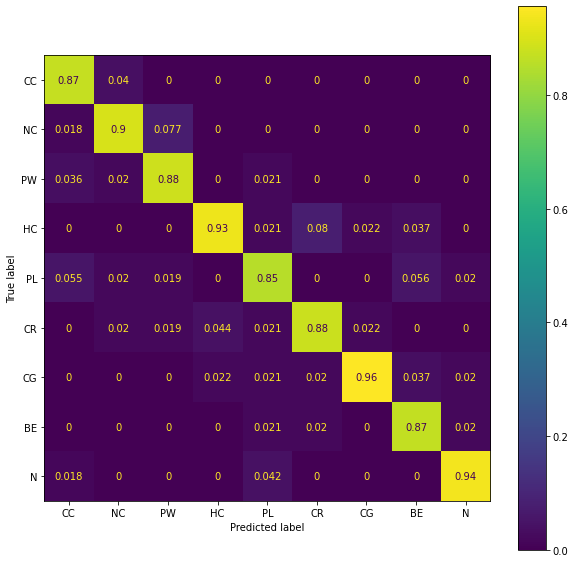

In [28]:
# plot confusion matrix
cm = confusion_matrix(predictions[1], y_pred , normalize='pred')
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)